In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import Dataset
from sklearn.model_selection import train_test_split
import re
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# Load the dataset
file_path = '/content/drive/MyDrive/deeplearning/teampro/unsmile_dataset.txt'
data = pd.read_csv(file_path, delimiter='\t')

In [10]:
# Merge labels
label_columns = ['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭']

def extract_labels(row):
    return [label_columns[i] for i in range(len(label_columns)) if row[i+1] == 1]

data['labels'] = data.apply(extract_labels, axis=1)

data['multi_class_label'] = data[label_columns].idxmax(axis=1)

# # 텍스트 클리닝 함수
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"[^a-zA-Z가-힣0-9\s]", "", text)
    return text.strip()

# 'comments' 열 클리닝
data['문장'] = data['문장'].apply(clean_text)

In [11]:
# # Encode Label & Make label column
id2label = {k:v for k, v in enumerate(data['multi_class_label'].unique())}
label2id = {v:k for k, v in id2label.items()}

data['labels'] = data['multi_class_label'].map(label2id)

In [12]:
# Split and Make Dataset
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

In [13]:
# Tokenize Dataset
tokenizer = BertTokenizer.from_pretrained('snunlp/KR-BERT-char16424')
def tokenize_data(data):
    encoded = tokenizer(
        data['문장'],
        max_length=512,
        truncation=True
    )
    encoded['labels'] = data['labels']
    return encoded

tokenized_train_dataset = train_dataset.map(tokenize_data, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_data, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_data, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/104k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Map:   0%|          | 0/14993 [00:00<?, ? examples/s]

Map:   0%|          | 0/1874 [00:00<?, ? examples/s]

Map:   0%|          | 0/1875 [00:00<?, ? examples/s]

In [14]:
# Load Collator
collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest'    # pad to longest sequence in batch
)

In [15]:
# Function to compute metrics
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    return {'accuracy': accuracy, 'f1': f1}

In [17]:
# Load arguments
training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=10,
        weight_decay=.01,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=3e-5,
        evaluation_strategy='steps',
        eval_steps=300,
        save_strategy='steps',
        save_steps=300,
        logging_strategy='steps',
        logging_steps=500,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
        greater_is_better=True,
        lr_scheduler_type='cosine',
        warmup_ratio=0.1,
        no_cuda=False

    )

class_weights = compute_class_weight('balanced', classes=np.unique(data['labels']), y=data['labels'])
class_weights = torch.tensor(class_weights, dtype=torch.float)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Load & Train model


model =  AutoModelForSequenceClassification.from_pretrained('snunlp/KR-BERT-char16424', id2label=id2label, label2id=label2id)
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # 여기서 클래스 가중치를 사용하여 손실 함수를 정의합니다.
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(self.model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# CustomTrainer 인스턴스 생성 및 훈련
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=collator,
    compute_metrics=compute_metrics
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainer.train()

pytorch_model.bin:   0%|          | 0.00/397M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snunlp/KR-BERT-char16424 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1
300,No log,2.027955,0.407150,0.385876
600,2.054900,1.019893,0.632871,0.629710
900,2.054900,0.858974,0.646211,0.639108
1200,1.022400,0.797063,0.722519,0.722605
1500,0.780200,0.775620,0.699039,0.694801
1800,0.780200,0.748382,0.723586,0.716826
2100,0.684500,0.788374,0.737460,0.732161
2400,0.684500,0.811598,0.717182,0.715942
2700,0.465200,0.795384,0.747065,0.744324
3000,0.382600,0.999713,0.742796,0.741100


TrainOutput(global_step=9380, training_loss=0.33714866734771076, metrics={'train_runtime': 2389.8569, 'train_samples_per_second': 62.736, 'train_steps_per_second': 3.925, 'total_flos': 4710059073285888.0, 'train_loss': 0.33714866734771076, 'epoch': 10.0})

In [19]:
# Evaluate the final model on the test set
test_results = trainer.evaluate(tokenized_test_dataset)

print(f"Test Accuracy: {test_results['eval_accuracy']}")
print(f"Test F1 Score: {test_results['eval_f1']}")

Test Accuracy: 0.7557333333333334
Test F1 Score: 0.7535098357546418


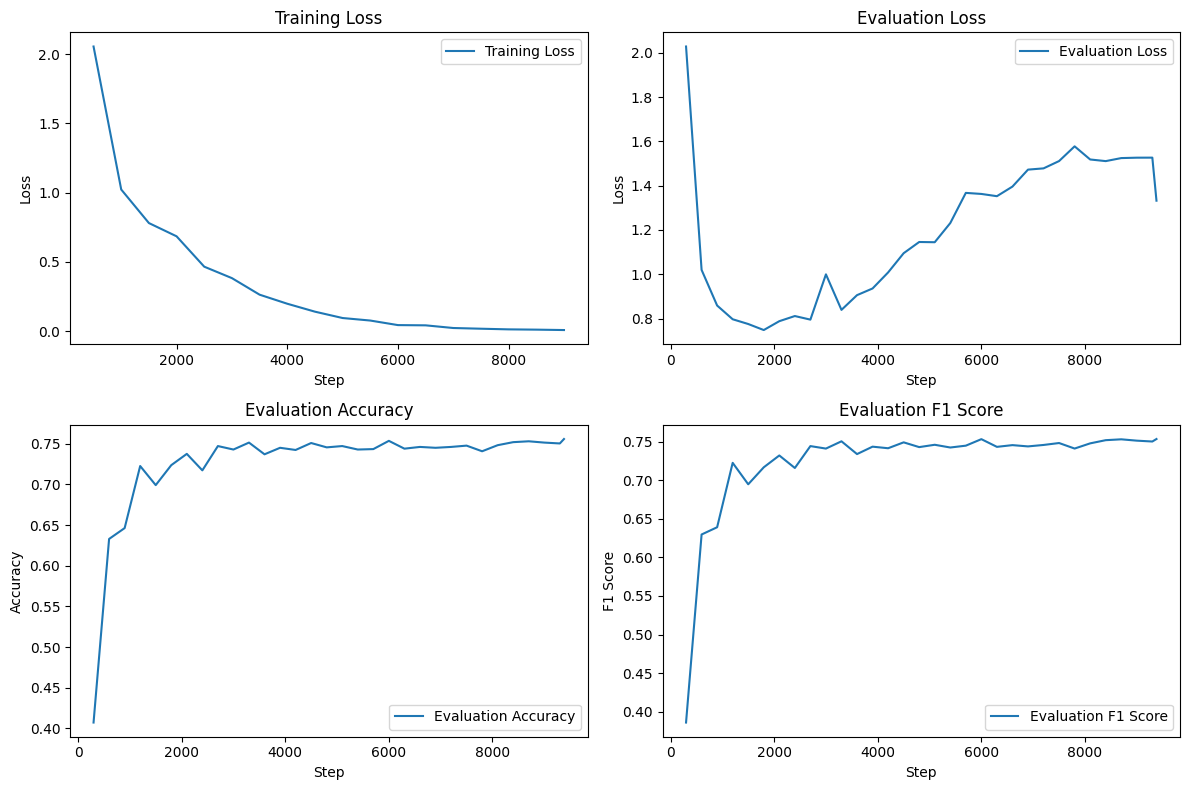

In [20]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Creating the plots
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(eval_steps, eval_f1, label='Evaluation F1 Score')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('F1 Score')
plt.title('Evaluation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

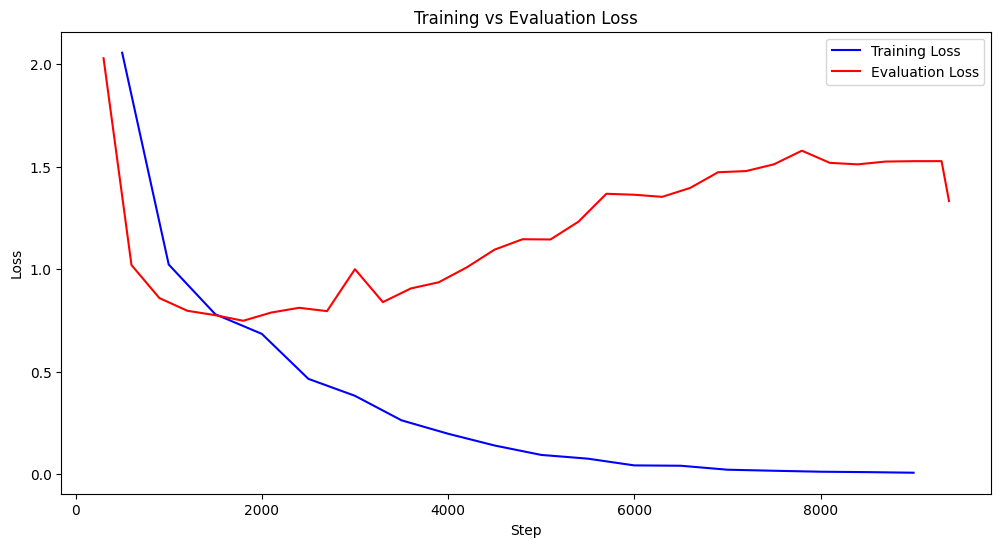

In [21]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Plotting Loss (Training and Evaluation on the same graph)
plt.figure(figsize=(12, 6))

plt.plot(train_steps, train_loss, label='Training Loss', color='blue')
plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
